<a href="https://colab.research.google.com/github/tomdyer10/fake_news/blob/master/captum_interp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Notebook Summary:**

Applying the Captum interpretability library to our news reliability classifier model, outputting word importances for the given classification. 

Shout out to members of the London Fast AI study group who also did great work on this topic.

References:

Captum docs - https://captum.ai/

Integrated Gradients paper - https://arxiv.org/abs/1703.01365


In [2]:
!pip install captum
!pip install transformers

In [0]:
import pandas as pd 
import numpy as np


import torch
import torch.optim as optim

import random 

# fastai
from fastai import *
from fastai.text import *
from fastai.callbacks import *

# transformers
from transformers import PreTrainedModel, PreTrainedTokenizer, PretrainedConfig
from transformers import BertForSequenceClassification, BertTokenizer, BertConfig
from transformers import AdamW

from functools import partial

# Define helper functions for fastai+bert integration

More detailed run through of this code found in model training notebook.

In [0]:
model_type = 'bert'
pretrained_model_name='bert-base-uncased'

model_class = BertForSequenceClassification
tokenizer_class = BertTokenizer
config_class = BertConfig

class TransformersBaseTokenizer(BaseTokenizer):
    """Wrapper around PreTrainedTokenizer to be compatible with fast.ai"""
    def __init__(self, pretrained_tokenizer: PreTrainedTokenizer, model_type = 'bert', **kwargs):
        self._pretrained_tokenizer = pretrained_tokenizer
        #halving max_seq_len to reduce strain on colab gpu
        self.max_seq_len = 350
        self.model_type = model_type

    def __call__(self, *args, **kwargs): 
        return self

    def tokenizer(self, t:str) -> List[str]:
        """Limits the maximum sequence length and add the spesial tokens"""
        CLS = self._pretrained_tokenizer.cls_token
        SEP = self._pretrained_tokenizer.sep_token
        tokens = self._pretrained_tokenizer.tokenize(t)[:self.max_seq_len - 2]
        tokens = [CLS] + tokens + [SEP]
        return tokens
        
transformer_tokenizer = tokenizer_class.from_pretrained(pretrained_model_name)
transformer_base_tokenizer = TransformersBaseTokenizer(pretrained_tokenizer = transformer_tokenizer, model_type = model_type)
fastai_tokenizer = Tokenizer(tok_func = transformer_base_tokenizer, pre_rules=[], post_rules=[])

In [0]:
class TransformersVocab(Vocab):
    def __init__(self, tokenizer: PreTrainedTokenizer):
        super(TransformersVocab, self).__init__(itos = [])
        self.tokenizer = tokenizer
    
    def numericalize(self, t:Collection[str]) -> List[int]:
        "Convert a list of tokens `t` to their ids."
        return self.tokenizer.convert_tokens_to_ids(t)
        #return self.tokenizer.encode(t)

    def textify(self, nums:Collection[int], sep=' ') -> List[str]:
        "Convert a list of `nums` to their tokens."
        nums = np.array(nums).tolist()
        return sep.join(self.tokenizer.convert_ids_to_tokens(nums)) if sep is not None else self.tokenizer.convert_ids_to_tokens(nums)
        
    def __getstate__(self):
        return {'itos':self.itos, 'tokenizer':self.tokenizer}

    def __setstate__(self, state:dict):
        self.itos = state['itos']
        self.tokenizer = state['tokenizer']
        self.stoi = collections.defaultdict(int,{v:k for k,v in enumerate(self.itos)})


transformer_vocab =  TransformersVocab(tokenizer = transformer_tokenizer)
numericalize_processor = NumericalizeProcessor(vocab=transformer_vocab)

tokenize_processor = TokenizeProcessor(tokenizer=fastai_tokenizer, 
                                       include_bos=False, 
                                       include_eos=False)

transformer_processor = [tokenize_processor, numericalize_processor]

In [0]:
class CustomTransformerModel(nn.Module):
  
    def __init__(self, transformer_model: PreTrainedModel):
        super(CustomTransformerModel,self).__init__()
        self.transformer = transformer_model
        
    def forward(self, input_ids):
        # Return only the logits from the transfomer
        logits = self.transformer(input_ids)[0]   
        return logits

config = config_class.from_pretrained(pretrained_model_name)
config.num_labels = 2

transformer_model = model_class.from_pretrained(pretrained_model_name, config = config)
custom_transformer_model = CustomTransformerModel(transformer_model = transformer_model)

In [0]:

CustomAdamW = partial(AdamW, correct_bias=False)

In [8]:
bert = load_learner('drive/My Drive/fake_news_1/models/', 'fastai+bert.pkl')

In [9]:
bert.model.eval()

CustomTransformerModel(
  (transformer): BertForSequenceClassification(
    (bert): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0): BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, out_feature

# Load Data and Create Databunch

This will allow us to utilise the above tokenizing functions in a single call of one_item

In [0]:
path = 'drive/My Drive/fake_news_1/data/train.csv'
df = pd.read_csv(path)
df = df.dropna()
df = df.sample(n=100)

In [11]:
pad_first = False
pad_idx = transformer_tokenizer.pad_token_id
seed = 42
bs=12

databunch = (TextList.from_df(df, cols='text', processor=transformer_processor)
             .split_by_rand_pct(0.1,seed=seed)
             .label_from_df(cols= 'label')
             .databunch(bs=bs, pad_first=pad_first, pad_idx=pad_idx))

Tokenize single sentence

In [12]:
x, y = databunch.one_item('this is a very short news report')
x

tensor([[ 101, 2023, 2003, 1037, 2200, 2460, 2739, 3189,  102]])

In [13]:
bert.model(x)

tensor([[-1.2859,  1.7003]], grad_fn=<AddmmBackward>)

Reverse tokenizer

In [0]:
# transformer_vocab.textify(x[0])

# Implement Captum

In [0]:
from captum.attr import LayerIntegratedGradients, TokenReferenceBase, visualization

Define forward function with softmax

In [16]:
forward_func = lambda x: torch.softmax(bert.model(x)[0], dim=-1)
forward_func(x)

tensor([0.0481, 0.9519], grad_fn=<SoftmaxBackward>)

Define BERT embedding layer for integrated gradients

In [17]:
embedding_layer = bert.model.transformer.bert.embeddings
embedding_layer(x).shape

torch.Size([1, 9, 768])

Init layered integrated gradients

In [0]:
lig = LayerIntegratedGradients(forward_func, embedding_layer)

In [19]:
sentence = 'This is a clip of real, totally real news man'
sentence_tokens = bert.data.one_item(sentence)[0]
sentence_tokens

tensor([[  101,  2023,  2003,  1037, 12528,  1997,  2613,  1010,  6135,  2613,
          2739,  2158,   102]])

In [20]:
transformer_vocab.tokenizer.pad_token_id

0

In [21]:
transformer_vocab.tokenizer.cls_token_id

101

Create baseline

In [22]:
baseline = torch.zeros_like(sentence_tokens)
baseline[0,0] = 101
baseline[0, -1] = 102
baseline.shape

torch.Size([1, 13])

In [23]:
sentence_tokens.shape

torch.Size([1, 13])

In [0]:
# attrs, delta = lig.attribute(sentence_tokens, baseline, n_steps=100, return_convergence_delta=True)
# attrs.shape

# Visualize outputs

(only able to visualize a sample section of text given memory constraints)

Lets get some example text

In [74]:
df.iloc[4]

id                                                    20115
title     Florida: Taco Trucks Used to “Lure” Democrat V...
author                                                admin
text      Information Liberation October 26, 2016 \nVide...
label                                                     1
Name: 20115, dtype: object

Create tokens and baseline for our selected text

In [0]:
target = df['label'].iloc[4]
text = df['text'].iloc[4][:300]
tokens = bert.data.one_item(text)[0]
baseline = torch.zeros_like(tokens)
baseline[0,0] = 101
baseline[0, -1] = 102

In [76]:
print(baseline)

tensor([[101,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0, 102]])


In [0]:
_, predicted, raw_probs = bert.predict(text)

In [78]:
print(target, predicted, raw_probs, text)

1 tensor(1) tensor([6.0312e-06, 9.9999e-01]) Information Liberation October 26, 2016 
Video out of Florida shows the Clinton machine is busing people to the polls and luring them to vote using taco trucks. 
Now we know what the DNC meant when they said they needed more “ taco bowl outreach .” 
SEIU, which has endorsed Hillary Clinton, appears 


We are getting the correct prediction even on a small section of the text.

In [0]:
attrs, delta = lig.attribute(tokens, baseline, n_steps=150, return_convergence_delta=True)

In [87]:
attrs

tensor([[[ 0.0000e+00,  0.0000e+00, -0.0000e+00,  ..., -0.0000e+00,
          -0.0000e+00, -0.0000e+00],
         [ 9.6523e-14,  3.0605e-14,  6.5893e-15,  ..., -2.7715e-14,
          -4.6802e-14,  4.6282e-14],
         [ 2.3694e-14, -5.2723e-14, -6.1399e-15,  ..., -8.1856e-15,
          -1.2553e-13,  1.2239e-13],
         ...,
         [ 3.6491e-15,  1.2927e-13,  2.8489e-15,  ...,  3.4090e-14,
          -8.3216e-14, -5.6480e-15],
         [ 3.6905e-13, -3.1450e-14, -1.3440e-14,  ...,  5.1686e-14,
          -1.5232e-14, -1.9266e-13],
         [-0.0000e+00,  0.0000e+00,  0.0000e+00,  ..., -0.0000e+00,
           0.0000e+00,  0.0000e+00]]], dtype=torch.float64,
       grad_fn=<MulBackward0>)

Normalize attributions

In [88]:
a = attrs.sum(-1)
a = a / torch.norm(a)
a[0]

tensor([ 0.0000, -0.2010, -0.2404,  0.2476,  0.1297,  0.0631, -0.0952,  0.0583,
        -0.0328,  0.0684,  0.2588,  0.0171,  0.1149,  0.0924,  0.1528,  0.0437,
         0.1437,  0.0629,  0.2982, -0.1096, -0.0021,  0.0324,  0.0880, -0.1482,
         0.0072, -0.0543, -0.0595, -0.1094, -0.1138,  0.0164, -0.0829,  0.1093,
        -0.0540, -0.0763, -0.1269, -0.1489,  0.0913,  0.0856, -0.1059,  0.1419,
         0.0631, -0.0348,  0.0540,  0.0551,  0.0722, -0.0370, -0.0397, -0.1115,
        -0.1484, -0.1915, -0.0861,  0.2459, -0.0108,  0.0877, -0.1890,  0.0301,
         0.0384,  0.0907,  0.0408,  0.1433,  0.0591,  0.2854, -0.2558,  0.0356,
         0.0000], dtype=torch.float64, grad_fn=<SelectBackward>)

In [0]:
tokenized_text = transformer_base_tokenizer.tokenizer(text)

In [90]:
len(tokenized_text), len(a[0])

(65, 65)

Visualize individual word attributions

In [0]:
viz_record = visualization.VisualizationDataRecord(a[0], raw_probs[predicted], predicted, target, target, a.sum(), tokenized_text, delta)

In [95]:
visualization.visualize_text([viz_record])

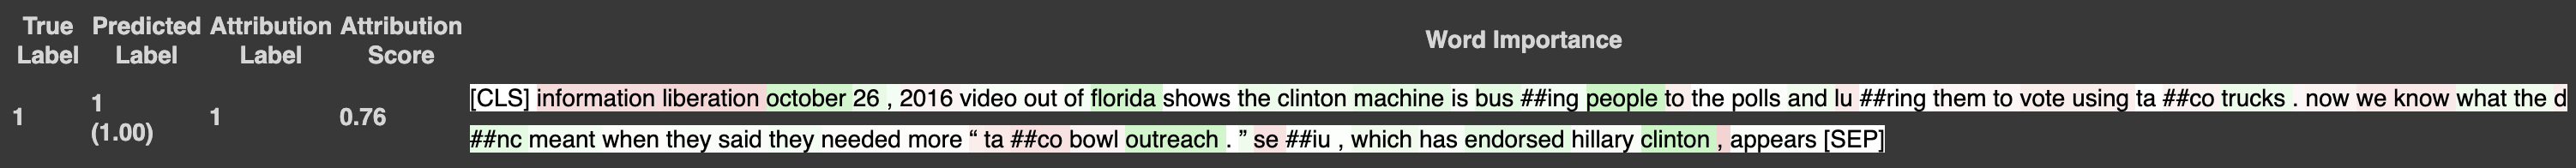